In [22]:
# Get Elastic Search tools
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import re
import json
import sys
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

jobids={}

fr_sq={}
squids=[]
frservers=[]
for i in ['034','036','146','147']:
  frservers.append('aiatlas'+i+'.cern.ch')
for i in range(1,7):
  squids.append('ca'+str("%02d"%i)+'.cern.ch')
for i in range(10,15):
  squids.append('ca'+str("%02d"%i)+'.cern.ch')
for i in range(len(frservers)):
  fr_sq[(frservers[i],'other')]=0
  for j in range(len(squids)):
    fr_sq[(frservers[i],squids[j])]=0
#    if i == 0:
#      fr_sq[('other',squids[j])]=0
#frservers.append('other')
squids.append('other')
#fr_sq[('other','other')]=0

es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

myquery = {
  "size": 10000,
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "taskid:11164025",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "range": {
            "@timestamp": {
              "gte": "20170412T000000.000Z",
              "lte": "20170415T000000.000Z",
              "format": "basic_date_time"
            }
          }
        }
      ],
      "must_not": []
    }
  }
}

res_page = es.search(index='frontier-*', body=myquery, request_timeout=600, scroll='2m')

sid = res_page['_scroll_id']
print(res_page['hits']['total'])
scroll_size=res_page['hits']['total']

for i in range(len(res_page['hits']['hits'])):
  frs=str(res_page['hits']['hits'][i]['_source']['frontierserver'])
  sq=str(res_page['hits']['hits'][i]['_source']['squid'])
#  if frs in frservers:
  if sq in squids:
    fr_sq[(frs,sq)]+=1
  else:
    fr_sq[(frs,'other')]+=1
#  elif sq in squids:
#      fr_sq[('other',sq)]+=1
#  else:
#      fr_sq[('other','other')]+=1
  jid=res_page['hits']['hits'][i]['_source']['pandaid']
  if not jid in jobids.keys():
    jobids[jid]=0
  else:
    jobids[jid]+=1

# Start scrolling
while (scroll_size > 0):
  print "Scrolling..."
  res_page = es.scroll(scroll_id = sid, scroll = '2m')
  # Update the scroll ID
  sid = res_page['_scroll_id']
  # Get the number of results that we returned in the last scroll
  scroll_size = len(res_page['hits']['hits'])
  print "scroll size: " + str(scroll_size)
  # Do something with the obtained page

  for i in range(len(res_page['hits']['hits'])):
    frs=str(res_page['hits']['hits'][i]['_source']['frontierserver'])
    sq=str(res_page['hits']['hits'][i]['_source']['squid'])
#    if frs in frservers:
    if sq in squids:
      fr_sq[(frs,sq)]+=1
    else:
      fr_sq[(frs,'other')]+=1
#    elif sq in squids:
#        fr_sq[('other',sq)]+=1
#    else:
#        fr_sq[('other','other')]+=1
    jid=res_page['hits']['hits'][i]['_source']['pandaid']
    if not jid in jobids.keys():
      jobids[jid]=1
    else:
      jobids[jid]+=1

print len(frservers), frservers;
print
print len(squids), squids;
print
print len(fr_sq), fr_sq;
print
print jobids
print
print 'Number of jobs: ', len(jobids)

9714
Scrolling...
scroll size: 0
4 ['aiatlas034.cern.ch', 'aiatlas036.cern.ch', 'aiatlas146.cern.ch', 'aiatlas147.cern.ch']

12 ['ca01.cern.ch', 'ca02.cern.ch', 'ca03.cern.ch', 'ca04.cern.ch', 'ca05.cern.ch', 'ca06.cern.ch', 'ca10.cern.ch', 'ca11.cern.ch', 'ca12.cern.ch', 'ca13.cern.ch', 'ca14.cern.ch', 'other']

48 {('aiatlas034.cern.ch', 'other'): 1498, ('aiatlas147.cern.ch', 'other'): 934, ('aiatlas036.cern.ch', 'other'): 1359, ('aiatlas147.cern.ch', 'ca06.cern.ch'): 134, ('aiatlas146.cern.ch', 'ca13.cern.ch'): 112, ('aiatlas034.cern.ch', 'ca06.cern.ch'): 89, ('aiatlas147.cern.ch', 'ca11.cern.ch'): 108, ('aiatlas147.cern.ch', 'ca05.cern.ch'): 141, ('aiatlas146.cern.ch', 'ca14.cern.ch'): 100, ('aiatlas146.cern.ch', 'ca05.cern.ch'): 122, ('aiatlas036.cern.ch', 'ca06.cern.ch'): 98, ('aiatlas146.cern.ch', 'ca01.cern.ch'): 148, ('aiatlas146.cern.ch', 'ca04.cern.ch'): 138, ('aiatlas147.cern.ch', 'ca13.cern.ch'): 127, ('aiatlas034.cern.ch', 'ca03.cern.ch'): 140, ('aiatlas146.cern.ch', 'ca0

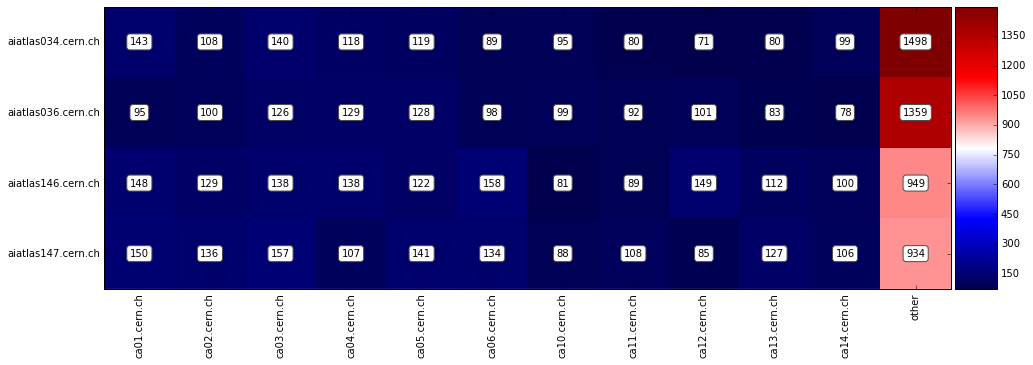

In [24]:
#
# Plot showing matrix of frontier servers and squids
#
x_header = squids
y_header = frservers

data=[]
for i in range(len(frservers)):
  aux=[]
  for j in range(len(squids)):
    aux.append(fr_sq[(frservers[i],squids[j])])
  data.append(aux)

arr = np.array(data)
fig_size=[]
fig_size.append(16)
fig_size.append(20)
plt.rcParams["figure.figsize"] = fig_size
fig, ax = plt.subplots()
ax.set_xticks(np.arange(arr.shape[1]), minor=False)
ax.set_yticks(np.arange(arr.shape[0]), minor=False)
ax.set_xticklabels(x_header, rotation=90)
ax.set_yticklabels(y_header)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.imshow(data, cmap=plt.cm.seismic, interpolation='none')
fig.colorbar(im, cax=cax)

for i in range(len(squids)):
  for j in range(len(frservers)):
    ax.text(i, j, str(data[j][i]), ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.show()

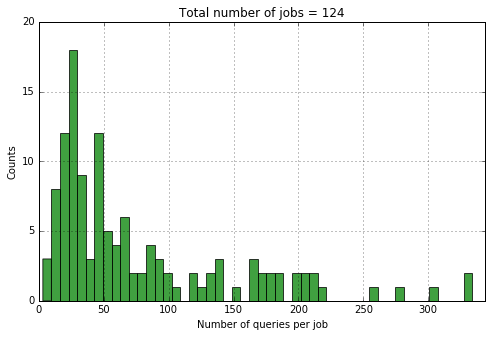

In [34]:
#
# Plot showing histogram of number of queries per job 
#

# the histogram of the data
n, bins, patches = plt.hist(jobids.values(), 50, facecolor='green', alpha=0.75)

plt.xlabel('Number of queries per job')
plt.ylabel('Counts')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([0, max(jobids.values())+10, 0, 20])
plt.grid(True)
#plt.text(0,0, 'Total number of jobs = '+str(len(jobids)))  
plt.title('Total number of jobs = '+str(len(jobids)))

fig_size=[]
fig_size.append(8)
fig_size.append(4)
plt.rcParams["figure.figsize"] = fig_size

plt.show()